In [ ]:
!pip install tensorflow matplotlib seaborn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:


df = pd.read_csv("Emotion_final.csv")
df.head()


,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


<ipython-input-4-993564fc36c3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Emotion', data=df, palette='Set2')


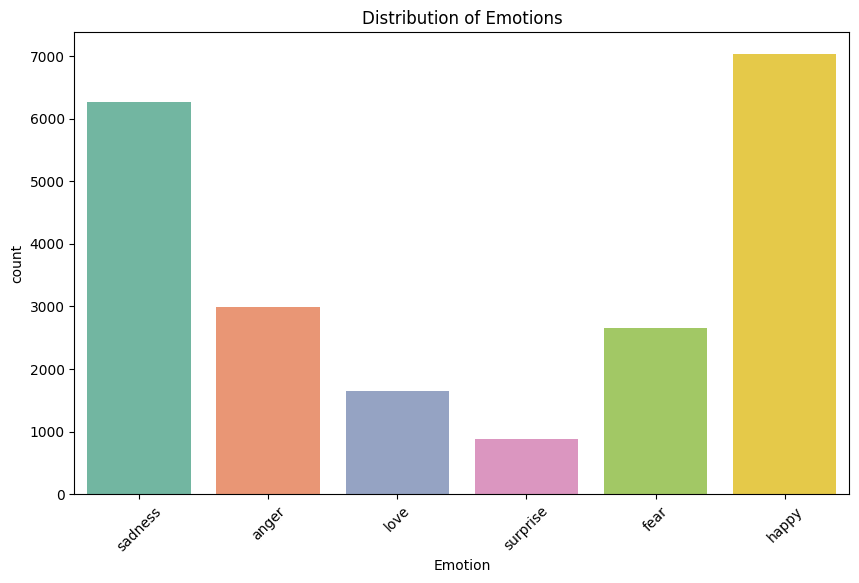

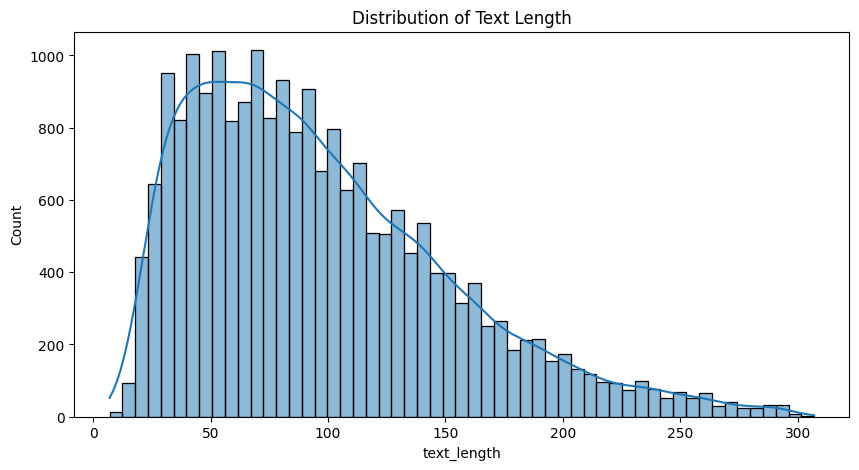

In [ ]:
# Distribution plot
plt.figure(figsize=(10,6))
sns.countplot(x='Emotion', data=df, palette='Set2')
plt.title("Distribution of Emotions")
plt.xticks(rotation=45)
plt.show()

# Text length distribution
df['text_length'] = df['Text'].apply(len)
plt.figure(figsize=(10,5))
sns.histplot(df['text_length'], kde=True)
plt.title("Distribution of Text Length")
plt.show()


In [ ]:
import re

def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^A-Za-z\s]", "", text)
    text = text.lower()
    return text

df['Clean_Text'] = df['Text'].apply(clean_text)

# Encode labels
label_enc = LabelEncoder()
df['Emotion_Label'] = label_enc.fit_transform(df['Emotion'])


In [ ]:
# Parameters
MAX_WORDS = 10000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Clean_Text'])

sequences = tokenizer.texts_to_sequences(df['Clean_Text'])
X = pad_sequences(sequences, maxlen=MAX_LEN)
y = tf.keras.utils.to_categorical(df['Emotion_Label'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
input_layer = Input(shape=(MAX_LEN,))
embedding = Embedding(input_dim=MAX_WORDS, output_dim=128)(input_layer)
lstm = Bidirectional(LSTM(64, return_sequences=True))(embedding)
cnn = Conv1D(64, kernel_size=3, activation='relu')(lstm)
pooling = GlobalMaxPooling1D()(cnn)
dropout = Dropout(0.5)(pooling)
dense = Dense(64, activation='relu')(dropout)
output_layer = Dense(y.shape[1], activation='softmax')(dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 98, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,408,006 (5.37 MB)

 Trainable params: 1,408,006 (5.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=20,
                    batch_size=64,
                    callbacks=[early_stop])


Epoch 1/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 79s 293ms/step - accuracy: 0.9704 - loss: 0.0851 - val_accuracy: 0.9075 - val_loss: 0.3328
Epoch 2/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 79s 292ms/step - accuracy: 0.9745 - loss: 0.0714 - val_accuracy: 0.9098 - val_loss: 0.3654
Epoch 3/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 79s 295ms/step - accuracy: 0.9792 - loss: 0.0560 - val_accuracy: 0.9059 - val_loss: 0.3855
Epoch 4/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 78s 290ms/step - accuracy: 0.9795 - loss: 0.0564 - val_accuracy: 0.9082 - val_loss: 0.4100


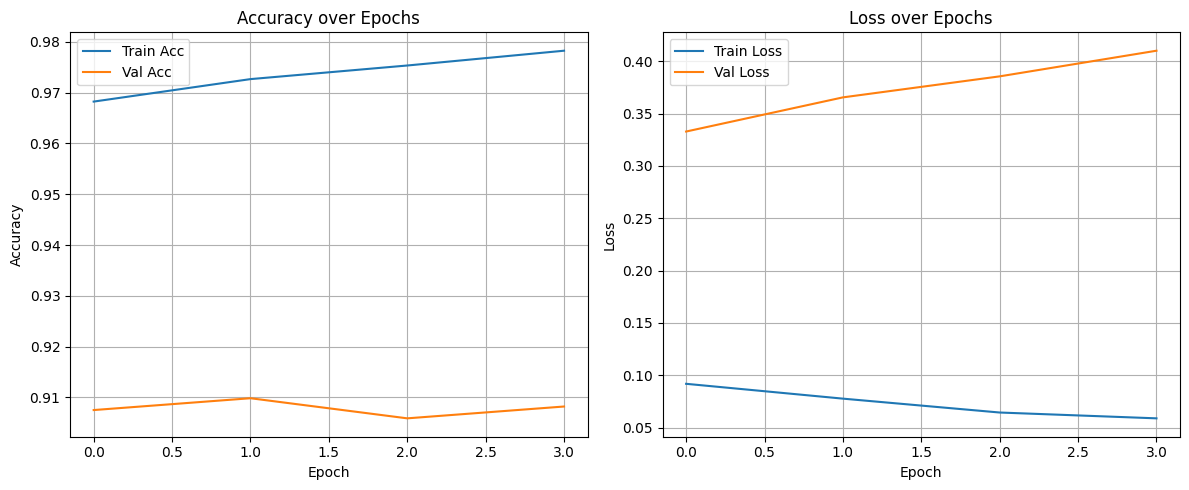

In [ ]:
 # Assuming you stored the model.fit() result as `history`
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step
Classification Report:
              precision    recall  f1-score      support
anger          0.876755  0.938230  0.906452   599.000000
fear           0.888235  0.854717  0.871154   530.000000
happy          0.927105  0.931721  0.929408  1406.000000
love           0.829721  0.817073  0.823349   328.000000
sadness        0.937795  0.950519  0.944114  1253.000000
surprise       0.822222  0.630682  0.713826   176.000000
accuracy       0.907502  0.907502  0.907502     0.907502
macro avg      0.880306  0.853824  0.864717  4292.000000
weighted avg   0.906656  0.907502  0.906358  4292.000000


<Figure size 1000x800 with 0 Axes>

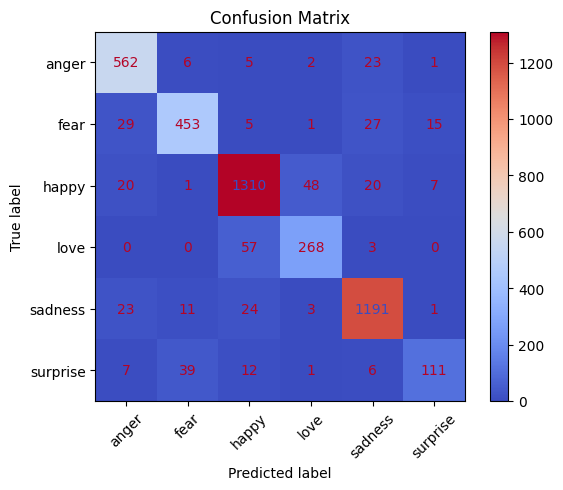

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Predict class probabilities on test set
y_pred_probs = model.predict(X_test)  # Get the class probabilities from the model
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded true labels to class labels

# Classification report
report = classification_report(
    y_true_classes,  # True labels
    y_pred_classes,  # Predicted labels
    target_names=label_enc.classes_,  # Class labels (e.g., from label encoder)
    output_dict=True  # Return as dictionary
)

# Convert the classification report to a DataFrame
report_df = pd.DataFrame(report).transpose()
print("Classification Report:")
print(report_df)

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)  # Generate confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_enc.classes_)

# Plot colored confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap='coolwarm', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


In [ ]:
# 1. Custom test inputs
custom_texts = [
    "I am feeling so happy today!",
    "This is the worst day ever",
    "I miss you a lot",
    "I am scared of tomorrow",
    "What a lovely surprise!",
    "Why are you yelling at me?",
    "I love spending time with you",
    "I can't stop crying",
    "I feel anxious and stressed",
    "You made my day!"
]

# 2. Define the same cleaning function used in training
def clean_text(text):
    import re
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 3. Preprocess
custom_clean = [clean_text(text) for text in custom_texts]
custom_seq = tokenizer.texts_to_sequences(custom_clean)
custom_pad = pad_sequences(custom_seq, maxlen=MAX_LEN)

# 4. Predict
preds = model.predict(custom_pad)
pred_classes = np.argmax(preds, axis=1)
pred_labels = label_enc.inverse_transform(pred_classes)
confidence_scores = np.max(preds, axis=1)

# 5. Print predictions with confidence scores
print("\n--- Predictions on Custom Texts ---\n")
for i, text in enumerate(custom_texts):
    print(f"{i+1}. \"{text}\"")
    print(f"   ➤ Predicted Emotion: {pred_labels[i]}")
    print(f"   ➤ Confidence Score: {confidence_scores[i]*100:.2f}%\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step

--- Predictions on Custom Texts ---

1. "I am feeling so happy today!"
   ➤ Predicted Emotion: happy
   ➤ Confidence Score: 100.00%

2. "This is the worst day ever"
   ➤ Predicted Emotion: surprise
   ➤ Confidence Score: 34.01%

3. "I miss you a lot"
   ➤ Predicted Emotion: surprise
   ➤ Confidence Score: 32.52%

4. "I am scared of tomorrow"
   ➤ Predicted Emotion: fear
   ➤ Confidence Score: 75.91%

5. "What a lovely surprise!"
   ➤ Predicted Emotion: love
   ➤ Confidence Score: 65.15%

6. "Why are you yelling at me?"
   ➤ Predicted Emotion: anger
   ➤ Confidence Score: 42.14%

7. "I love spending time with you"
   ➤ Predicted Emotion: surprise
   ➤ Confidence Score: 29.36%

8. "I can't stop crying"
   ➤ Predicted Emotion: anger
   ➤ Confidence Score: 30.39%

9. "I feel anxious and stressed"
   ➤ Predicted Emotion: fear
   ➤ Confidence Score: 99.91%

10. "You made my day!"
   ➤ Predicted Emotion: surprise
   ➤ Confidence Score: 24.55%

